In [58]:
import sys
sys.path.append('.')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import pyro

pyro.set_rng_seed(100)

In [60]:
from IPython.display import Code, display
import numpy as np
import pyro.distributions as dist

from src.mcmc import dataset
from src.mcmc import infer
from src.mcmc import model
from src.mcmc import vis

### Metropolis Hastings Sampler
https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

Implement the Metropolis Hastings Sampler based on the description provided in the link above. Use the code provided below to evaluate the correctnes of implementation.
In the file `src/mcmc/mhs.py` you can find an interface compatible with Pyro. Use it.

In [61]:
from src.mcmc import mhs

## Generate data

In [62]:
ds = dataset.generate_dataset(2000, train_size=0.6)

## Estimate model parameters 

In [63]:
posteriors = {}

In [64]:
mh_kernels = {
    ic: mhs.MetropolisHastings(
        model=model.speedometer_model,
        proposal_dist=lambda mean: dist.Normal(mean, 1.),
        priors={
            'c': lambda v: 1. if v > 0 else 0.,
            'std': lambda v: 1. if v > 0 else 0.,
        },
    )
    for ic in (0, 1)
}
         

posteriors['MetropolisHastings'] = {
    ic: infer.run_mcmc(
        kernel=mh_kernels[ic],
        model_args=(ds['train'][ic]['speed_limit'], ic, ds['train'][ic]['measurement']),
        num_samples=5000,
        warmup_steps=10,
    )
    for ic in (0, 1)
}

posteriors['MetropolisHastings'][0].summary()
posteriors['MetropolisHastings'][1].summary()

Sample: 100%|█████████████████████████████████████████████| 5010/5010 [00:07, 701.00it/s, #accepted=14, #rejected=9984]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.95      0.01      0.95      0.95      0.95     84.55      1.02
       std     10.84      1.11     11.02     10.83     11.77     16.51      1.09


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.74      0.00      0.75      0.74      0.75     29.24      1.05
       std      4.93      0.35      4.81      4.81      5.34     12.36      1.11



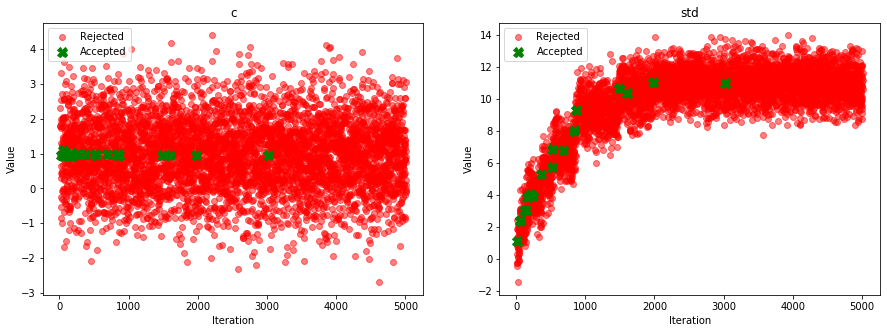

In [51]:
mhs.plot_accepted_rejected_samples(mh_kernels[0])

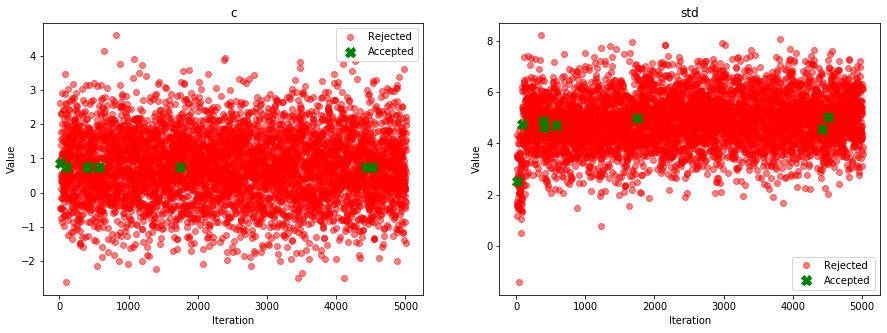

In [52]:
mhs.plot_accepted_rejected_samples(mh_kernels[1])

## Make predictors

In [54]:
from pyro.infer import Predictive

In [55]:
mcmc_predictive = {
    name: {
        ic: Predictive(
            lambda sl: model.speedometer_model(sl, ic),
            posterior_samples=infer.sample_mcmc(posteriors[name][ic]),
            return_sites=('measurement',)
        )
        for ic in (0, 1)
    }
    for name in ('MetropolisHastings',)
}

## Plot predictions and real samples

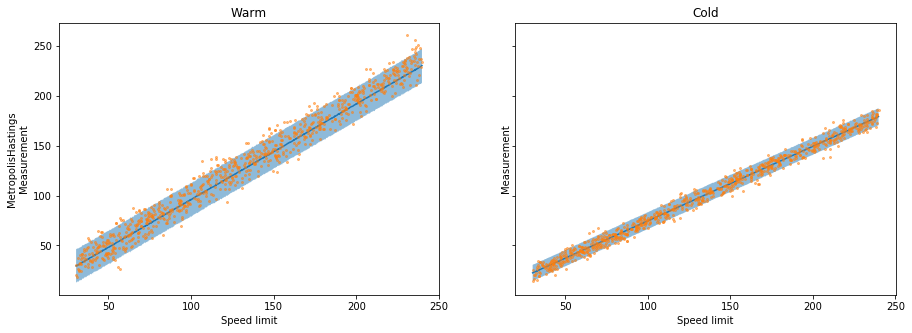

In [56]:
vis.plot_predictions(ds['test'], mcmc_predictive)